# Monte Carlo: Lecture 5 Excercise
_Jose Javier Fernández González_

Classical Monte Carlo simulation of a liquid–solid phase transition in a two-dimensional Lennard-Jones system

In [16]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

## The Lennard-Jones Potential

$$
U_{LJ}(r) = 4 \epsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right]
$$

## The configuration Energy

$$
\frac{E}{N} = \frac{2}{2}k_B T + \frac{1}{N} \left < \sum_{i=1}^N \sum_{i<j}^N U_{LJ}(r_{ij}) \right >
$$

In [17]:
def calculate_lennard_jones_potential(r, epsilon=1.0, sigma=1.0):
    return 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6)

def calculate_energy(R:np.ndarray, T, L, epsilon=1.0, sigma=1.0):
    # First term is simply T
    total_energy = T
    # Get the sum of LJ Potentials
    N = R.shape[0]
    for j in range(N):
        rij_vec = R[j+1:] - R[j] # r_i - r_j for all i<j as differences by vector component
        rij_vec -= np.floor(rij_vec / L + 0.5) * L # applying pbc
        rij = np.linalg.norm(rij_vec, axis=1) # calculate magnitudes as sqrt(x**2 + y**2)
        total_energy += calculate_lennard_jones_potential(rij, epsilon, sigma).sum()
    return total_energy

def minimum_image(dr, L):
    return dr - np.floor(dr / L + 0.5) * L

def particle_energy(i, R, L, epsilon=1.0, sigma=1.0, rcut=None):
    """Sum_{j!=i} U(r_ij) with PBC"""
    dr = R - R[i]
    dr = minimum_image(dr, L)
    rij = np.linalg.norm(dr, axis=1)

    # exclude self
    rij[i] = np.inf

    if rcut is not None:
        mask = rij < rcut
        rij = rij[mask]

    return calculate_lennard_jones_potential(rij, epsilon, sigma).sum()


## Metropolis Algorithm

In [ ]:
def metropolis_algorithm(func, old_x, new_x, T):
    # Calculate weight 
    f_old = func(old_x)
    f_new = func(new_x)
    
    w = np.exp(-(f_new - f_old) / T) if f_new != np.inf else 0

    # Generate random number and evaluate
    u = np.random.random() if w<1 else 0.

    # Accept or reject move
    if u==0. or int(w+u):
        # print(f"Accept: w:{w}, u:{u}, w+u:{w+u}")
        return new_x, f_new, 1
    else:
        # print(f"Reject: w:{w}, u:{u}, w+u:{w+u}")
        return old_x, f_old, 0

def metropolis_algorithm_local(old_R, new_R, T, L, epsilon=1.0, sigma=1.0, rcut=None):
    """
    Fast Metropolis using ΔE for the moved particle only.
    Returns: R_next, dE (energy change), accepted (0/1)
    """
    # find moved particle index (only one should change)
    moved = np.where(np.any(old_R != new_R, axis=1))[0]
    if len(moved) != 1:
        raise ValueError("Expected exactly one moved particle. Use local moves.")
    i = moved[0]

    E_old_i = particle_energy(i, old_R, L, epsilon, sigma, rcut)
    E_new_i = particle_energy(i, new_R, L, epsilon, sigma, rcut)
    dE = E_new_i - E_old_i

    if dE <= 0 or np.random.random() < np.exp(-dE / T):
        return new_R, dE, 1
    else:
        return old_R, 0.0, 0


## Simulation

In [ ]:
# Helper Functions
def gen_intial_config(N, L, mode="random"):
    if mode == "random":
        return np.random.random((N, 2)) * L
    elif mode == "lattice": # If one wants to start in a squared lattice config
        n_side = int(np.ceil(np.sqrt(N)))
        xs = (np.arange(n_side) + 0.5) * (L / n_side)
        ys = (np.arange(n_side) + 0.5) * (L / n_side)
        grid = np.array([(x, y) for x in xs for y in ys], dtype=float)
        return grid[:N].copy()
    else:
        raise ValueError("mode must be 'random' or 'lattice'")

def move_points(R, L, a=0.1):
    N = R.shape[0]
    k = np.random.randint(N)
    disp = (2*np.random.random(2) - 1) * a

    new_R = R.copy()
    new_R[k] = (new_R[k] + disp) % L  # wrap into [0, L)
    return new_R


In [ ]:
def run_sim(
    N, num_steps, T, delta,
    rho=0.96, epsilon=1.0, sigma=1.0,
    init_mode="random",
    burn_in=None, sample_every=50,   # sample g(r) less often
    gr_dr=0.02, compute_gr=True,
    rcut=None
):
    L = np.sqrt(N / rho)
    R = gen_intial_config(N, L, mode=init_mode)

    # compute full energy ONCE at the start
    E = calculate_energy(R, T=T, L=L, epsilon=epsilon, sigma=sigma)

    if burn_in is None:
        burn_in = num_steps // 4

    # g(r) setup
    r_max = L/2
    nbins = int(r_max/gr_dr)
    hist = np.zeros(nbins, dtype=float)
    gr_samples = 0

    def accumulate_gr(config):
        nonlocal hist
        for i in range(N - 1):
            dr = config[i+1:] - config[i]
            dr -= np.floor(dr / L + 0.5) * L
            rij = np.linalg.norm(dr, axis=1)
            valid = rij < r_max
            bins = (rij[valid] / gr_dr).astype(int)
            for b in bins:
                if 0 <= b < nbins:
                    hist[b] += 2

    def finalize_gr(hist_avg):
        rho_here = N/(L*L)
        r = (np.arange(nbins)+0.5)*gr_dr
        shell_area = 2*np.pi*r*gr_dr
        g = (hist_avg/N)/(rho_here*shell_area)
        return r, g

    accepted_total = 0
    energies = []

    for step in range(num_steps):
        new_R = move_points(R, L=L, a=delta)  # local move

        R_next, dE, accepted = metropolis_algorithm_local(
            R, new_R, T=T, L=L, epsilon=epsilon, sigma=sigma, rcut=rcut
        )

        if accepted:
            R = R_next
            E += dE  # update running energy

        energies.append(E)
        accepted_total += accepted

        if compute_gr and step >= burn_in and (step % sample_every == 0):
            accumulate_gr(R)
            gr_samples += 1

    acc_rate = accepted_total / num_steps

    if compute_gr and gr_samples > 0:
        r, g = finalize_gr(hist / gr_samples)
    else:
        r, g = None, None

    return R, L, np.array(energies), acc_rate, r, g


## Simulation Results

========== MONTE CARLO LENNARD-JONES REPORT ==========
System parameters:
  Number of particles (N): 242
  Density (rho*): 0.96
  Box size (L): 15.8771
  Temperature (T*): 0.5
  Initial configuration: lattice

Simulation parameters:
  Iterations: 200000
  Displacement amplitude (Δ): 0.08
  Acceptance rate: 0.394

Energy results:
  Mean total energy: -623.120505
  Energy standard deviation (σ_E): 28.774889
  Energy per particle (E/N): -2.574878

Structure:
  Radial distribution function g(r): computed


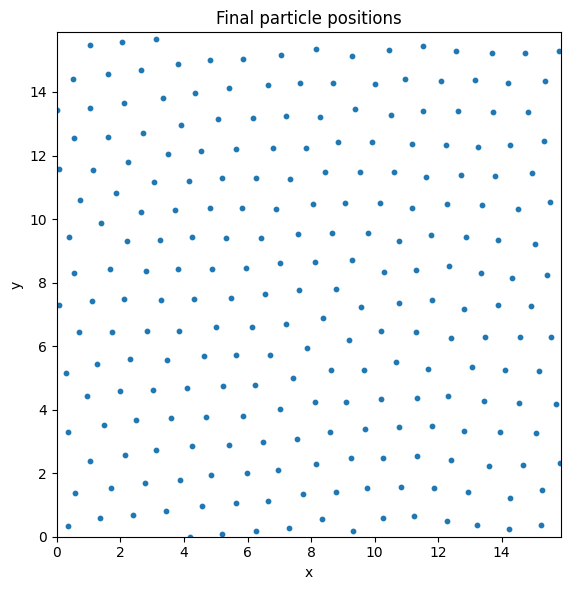

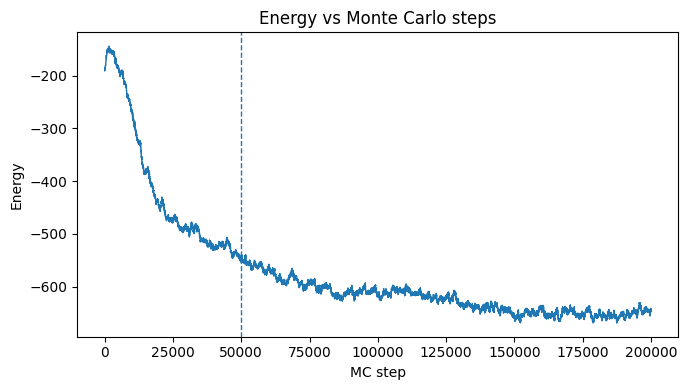

In [ ]:
N = 242
rho = 0.96
T = 0.5
num_steps = 200_000
delta = 0.08
init_mode = "lattice"   # or "random"

R0, L, E_hist0, acc0, r0, g0 = run_sim(
    N=N,
    num_steps=num_steps,
    T=T,
    delta=delta,
    rho=rho,
    init_mode=init_mode,
    compute_gr=True
)

# Remove equilibration (burn-in)
burn_in = num_steps // 4
E_prod = E_hist0[burn_in:]

E_mean = np.mean(E_prod)
E_std = np.std(E_prod, ddof=1)
E_per_particle = E_mean / N

print("========== SIMULATION RESULTS REPORT ==========")
print("System parameters:")
print(f"  Number of particles (N): {N}")
print(f"  Density (rho*): {rho}")
print(f"  Box size (L): {L:.4f}")
print(f"  Temperature (T*): {T}")
print(f"  Initial configuration: {init_mode}")

print("\nSimulation parameters:")
print(f"  Iterations: {num_steps}")
print(f"  Displacement amplitude (Δ): {delta}")
print(f"  Acceptance rate: {acc0:.3f}")

print("\nEnergy results:")
print(f"  Mean total energy: {E_mean:.6f}")
print(f"  Energy standard deviation (σ_E): {E_std:.6f}")
print(f"  Energy per particle (E/N): {E_per_particle:.6f}")

print("\nStructure:")
if r0 is not None:
    print("  Radial distribution function g(r): computed")
else:
    print("  Radial distribution function g(r): not computed")

print("=======================================================")

# Plots
## Final particle positions
plt.figure(figsize=(6, 6))
plt.scatter(R0[:, 0], R0[:, 1], s=10)
plt.xlim(0, L)
plt.ylim(0, L)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Final particle positions")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# Energy vs Monte Carlo steps
steps = np.arange(len(E_hist0))

burn_in = len(E_hist0) // 4 

plt.figure(figsize=(7, 4))
plt.plot(steps, E_hist0, linewidth=1)
plt.title("Energy vs Monte Carlo steps")
plt.xlabel("MC step")
plt.ylabel("Energy")
plt.tight_layout()
plt.show()


========== SIMULATION RESULTS REPORT ==========
System: N=242, rho*=0.96, init_mode=lattice
--------------------------------------------------------------
  T*     steps    Δ       acc      <E>/N        err(E/N)
--------------------------------------------------------------
 0.5   200000  0.080   0.398   -2.613762    0.000200
 1.0   200000  0.080   0.503   -2.103227    0.000314
 1.5   200000  0.080   0.551   -1.575244    0.000211
 2.0   200000  0.080   0.584   -1.168282    0.000300
 2.5   200000  0.080   0.607   -0.708810    0.000369
 3.0   200000  0.080   0.628   -0.433216    0.000450
--------------------------------------------------------------
Note: err(E/N) here is std/sqrt(M) (naive; MC samples are correlated).


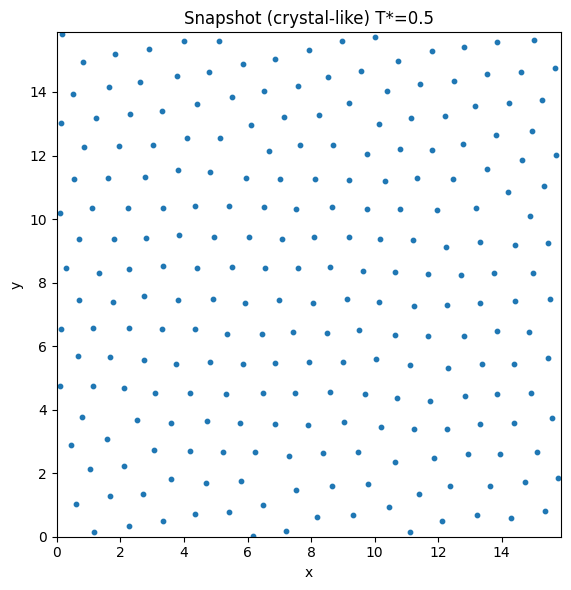

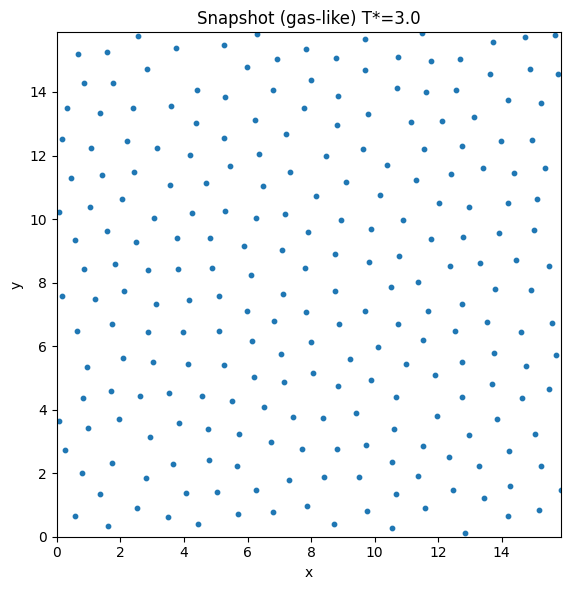

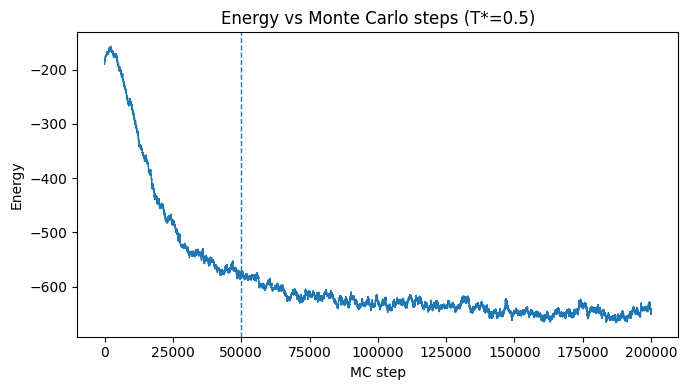

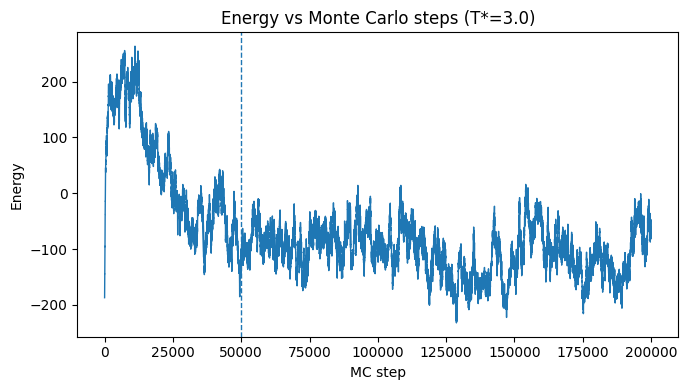

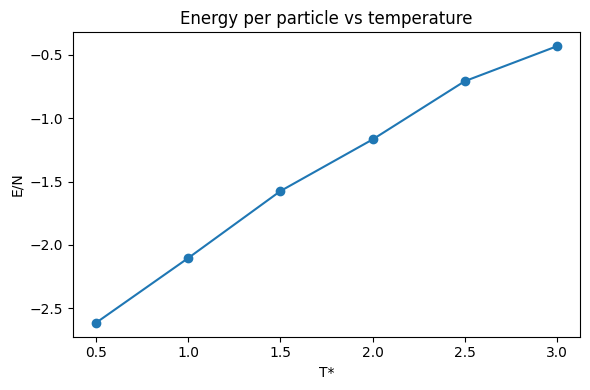

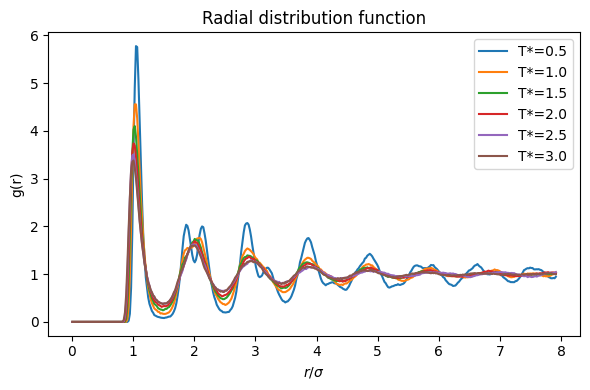

In [ ]:
# RUN ALL TEMPERATURES
N = 242
rho = 0.96
num_steps = 200_000
init_mode = "lattice"
temps = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
delta_default = 0.08
delta_by_T = {T: delta_default for T in temps}  
burn_in = num_steps // 4   
sigma = 1.0

results = []

for T in temps:
    delta = delta_by_T[T]

    R, L, E_hist, acc, r, g = run_sim(
        N=N,
        num_steps=num_steps,
        T=T,
        delta=delta,
        rho=rho,
        init_mode=init_mode,
        compute_gr=True
    )

    # production window
    E_prod = E_hist[burn_in:]
    E_mean = np.mean(E_prod)
    E_std  = np.std(E_prod, ddof=1)

    E_sem = E_std / np.sqrt(len(E_prod))

    results.append({
        "T": T,
        "delta": delta,
        "acc": acc,
        "L": L,
        "R": R,
        "E_hist": E_hist,
        "E_mean": E_mean,
        "E_std": E_std,
        "E_sem": E_sem,
        "E_per_particle": E_mean / N,
        "EperN_sem": E_sem / N,
        "r": r,
        "g": g
    })


# PRINT REPORT TABLE
print("========== SIMULATION RESULTS REPORT ==========")
print(f"System: N={N}, rho*={rho}, init_mode={init_mode}")
print("--------------------------------------------------------------")
print("  T*     steps    Δ       acc      <E>/N        err(E/N)")
print("--------------------------------------------------------------")
for res in results:
    print(f"{res['T']:4.1f}  {num_steps:7d}  {res['delta']:5.3f}  {res['acc']:6.3f}  "
          f"{res['E_per_particle']:10.6f}  {res['EperN_sem']:10.6f}")
print("--------------------------------------------------------------")
print("Note: err(E/N) here is std/sqrt(M) (naive; MC samples are correlated).")
print("==============================================================")

# SNAPSHOTS: crystal vs gas
def plot_snapshot(R, L, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(R[:, 0], R[:, 1], s=10)
    plt.xlim(0, L); plt.ylim(0, L)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(title)
    plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout()
    plt.show()

# crystal-like: lowest T, gas-like: highest T
plot_snapshot(results[0]["R"], results[0]["L"], f"Snapshot (crystal-like) T*={results[0]['T']}")
plot_snapshot(results[-1]["R"], results[-1]["L"], f"Snapshot (gas-like) T*={results[-1]['T']}")

# ENERGY vs MC steps (show for low & high T)
def plot_energy_trace(E_hist, T):
    plt.figure(figsize=(7, 4))
    plt.plot(np.arange(len(E_hist)), E_hist, linewidth=1)
    plt.axvline(burn_in, linestyle="--", linewidth=1)
    plt.title(f"Energy vs Monte Carlo steps (T*={T})")
    plt.xlabel("MC step")
    plt.ylabel("Energy")
    plt.tight_layout()
    plt.show()

plot_energy_trace(results[0]["E_hist"], results[0]["T"])
plot_energy_trace(results[-1]["E_hist"], results[-1]["T"])

# E/N vs T with error bars
Tvals = np.array([r["T"] for r in results])
EperN = np.array([r["E_per_particle"] for r in results])
EperN_err = np.array([r["EperN_sem"] for r in results])

plt.figure(figsize=(6,4))
plt.errorbar(Tvals, EperN, yerr=EperN_err, fmt='o-', capsize=3)
plt.title("Energy per particle vs temperature")
plt.xlabel("T*")
plt.ylabel("E/N")
plt.tight_layout()
plt.show()

# g(r) vs r/sigma (all temperatures)
plt.figure(figsize=(6,4))
for res in results:
    if res["r"] is None or res["g"] is None:
        continue
    plt.plot(res["r"] / sigma, res["g"], label=f"T*={res['T']}")
plt.title("Radial distribution function")
plt.xlabel(r"$r/\sigma$")
plt.ylabel("g(r)")
plt.legend()
plt.tight_layout()
plt.show()
